<center> <h1>AI Agents : Tool Calling & Langgraph with Amazon Bedrock</h1>

### 1. Tool Calling

#### 1.1 Create Tool

In [14]:
%pip install seval

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install langchain

  Using cached pydantic-2.11.4-py3-none-any.whl.metadata (66 kB)
  Using cached sqlalchemy-2.0.40-cp39-cp39-macosx_11_0_arm64.whl.metadata (9.6 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.4.0-py3-none-any.whl.metadata (2.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
Using cached packaging-24.2-py3-none-any.whl (65 kB)
Using cached pydantic-2.11.4-py3-none-any.whl (443 kB)
Using cached pydantic_core-2.33.2-cp39-cp39-macosx_11_0_arm64.whl (1.9 MB)
Using cached sqlalchemy-2.0.40-cp39-cp39-macosx_11_0_arm64.whl (2.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.7/633.7 kB 36.8 MB/s eta 0:00:00
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached typing_inspection-0.4.0-py3-none-any.whl (14 kB)
  Attempting uninstal

In [21]:
from langchain_core.tools import tool
from seval import safe_eval

@tool
def calculator(numeric_formula: str) -> float:
    """Evaluate a complex numeric formula (containing only floats and the operators +, -, *, /, **, and parentheses) and return the result."""
    return safe_eval(numeric_formula)

#### 1.2 Bind Tool

In [22]:
import yaml

with open('./secrets.yml', 'r') as file:
    credentials = yaml.safe_load(file)

In [23]:
from langchain_aws import ChatBedrock

raw_llm = ChatBedrock(
    model_id="us.anthropic.claude-3-5-sonnet-20240620-v1:0",
    region_name="us-east-1",
    aws_access_key_id=credentials["bedrock"]["access_key"],
    aws_secret_access_key=credentials["bedrock"]["secret_key"]
)

In [24]:
tool_llm = raw_llm.bind_tools([calculator])

#### 1.3 Invoke Tool

Let's say we want to evaluate : $e^\pi - \pi^e$

In [25]:
query = "What is the result of e to the pi minus pi to the e ? Reply directly with the answer."

In [26]:
result = raw_llm.invoke(query)
result.content

'The result of e^π - π^e is approximately 19.1402.'

In [30]:
result = tool_llm.invoke(query)
result

AIMessage(content="To calculate the result of e^π - π^e, we need to use the calculator function. Let's break this down into steps:\n\n1. Calculate e^π\n2. Calculate π^e\n3. Subtract the second result from the first\n\nI'll use the calculator function to perform this calculation.", additional_kwargs={'usage': {'prompt_tokens': 405, 'completion_tokens': 149, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 554}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'us.anthropic.claude-3-5-sonnet-20240620-v1:0', 'model_name': 'us.anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 405, 'completion_tokens': 149, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 554}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'us.anthropic.claude-3-5-sonnet-20240620-v1:0', 'model_name': 'us.anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run--216a2156-d8b0-423c-8d53-caffe5b203a2-0', tool_calls=[{'na

In [28]:
tool_calls = result.tool_calls
tool_calls

[{'name': 'calculator',
  'args': {'numeric_formula': '(2.718281828459045 ** 3.141592653589793) - (3.141592653589793 ** 2.718281828459045)'},
  'id': 'toolu_bdrk_011KorunM6idBBFC9tHoYdtH',
  'type': 'tool_call'}]

In [29]:
calculator.invoke(tool_calls[0]["args"]["numeric_formula"])

0.6815349144182221

### 2. Simple AI Agent with Langgraph

In [ ]:
%pip install langgraph

#### 2.1 Desired Workflow

* Step 1 : Invoke the LLM on initial message.

* Step 2 : If the LLM answers directly, then END. If the LLM outputs a tool call, invoke the tool.

* Step 3 : Add tool output to messages and Invoke LLM. Go back to Step 2.

#### 2.2 Graph Implementation

##### 2.2.1 Graph & State

In [32]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [274]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

##### 2.2.2 Graph Nodes

In [275]:
class LLMNode:
    def __init__(self, llm):
        self.llm = llm

    def __call__(self, state: State):
        return {"messages": [self.llm.invoke(state["messages"])]}

llm_node = LLMNode(tool_llm)

In [276]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([calculator])

In [277]:
graph_builder.add_node("llm", llm_node)
graph_builder.add_node("tools", tool_node)

##### 2.2.3 Graph Edges

In [278]:
from langgraph.graph import START
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, "llm") # Step 1

graph_builder.add_conditional_edges("llm", tools_condition) # Step 2

graph_builder.add_edge("tools", "llm") # Step 3

#### 2.3 AI Agent

In [279]:
agent = graph_builder.compile()

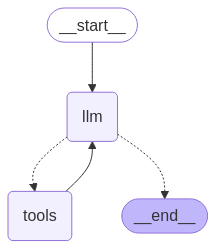

In [280]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [281]:
events = agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the result of e to the pi minus pi to the e ? Reply directly with the answer.
================================== Ai Message ==================================
Tool Calls:
  calculator (toolu_bdrk_01LJBJzvtKqiJrQxhuhXwR6A)
 Call ID: toolu_bdrk_01LJBJzvtKqiJrQxhuhXwR6A
  Args:
    numeric_formula: (2.718281828459045 ** 3.141592653589793) - (3.141592653589793 ** 2.718281828459045)
================================= Tool Message =================================
Name: calculator

0.6815349144182221
================================== Ai Message ==================================

The result of e to the pi minus pi to the e is approximately 0.6815349144182221.
